<a href="https://colab.research.google.com/github/RichardXiao13/Google_Code_In/blob/master/tf_keras_to_estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the required modules.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pyplot as plt

import numpy as np

try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

import tensorflow_datasets as tfds


TensorFlow 2.x selected.


Import the plant_village dataset from tensorflow datasets.

In [0]:
dataset, dataset_info = tfds.load("plant_village", with_info=True, as_supervised=True)

Get the number of classes in the plant village dataset. Create a training set with all images in the dataset.

In [0]:
NUM_CLASSES = dataset_info.features["label"].num_classes

num_ex = 0

training_set = dataset["train"]

Set the size of each image in the dataset to 240 pixels by 240 pixels. Define format_image as a function that resizes each image to previous dimensions and returns the image along with its label. Create training batches of 1000 images.

In [0]:
IMG_SIZE = 240

BATCH_SIZE = 1000

def format_image(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32)
  tf.image.resize(image, (IMG_SIZE, IMG_SIZE))/255.0
  image.set_shape([IMG_SIZE,IMG_SIZE,3])
  return image, label

In [0]:
training_batches = training_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

Create a model with 3 convoluted blocks and 2 dense layers. Inspect a summary of the model.

In [0]:
model = tf.keras.Sequential([
                             tf.keras.layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
                             tf.keras.layers.Conv2D(16, (3, 3), activation="relu", padding="same"),
                             tf.keras.layers.MaxPool2D(2, 2),

                             tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
                             tf.keras.layers.MaxPool2D(3, 3),

                             tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
                             tf.keras.layers.MaxPool2D(4, 4),

                             tf.keras.layers.Flatten(),

                             tf.keras.layers.Dense(512, activation="relu"),
                             tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
])

model.summary()

Compile the keras model using the ADAM optimizer, sparse categorical crossentropy loss and accuracy metrics.

In [0]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

Train the keras model using the training batches and validation batches. Set the epochs to 30.

In [0]:
EPOCHS = 30

history_keras = model.fit(training_batches,
                          epochs=EPOCHS
                          )

Create the input function for the estimator.

In [0]:
def input_training_function():
  data = tfds.load("plant_village", as_supervised=True)
  train = data["train"]
  train = train.map(format_image).repeat()
  return train.batch(BATCH_SIZE)

Create an estimator from the keras model.

In [0]:
estimator = tf.keras.estimator.model_to_estimator(keras_model=model)

Train the estimator using the same dataset.

In [0]:
history_estimator = estimator.train(input_fn=lambda: input_training_function(), steps=200)

Evaluate the estimator.

In [0]:
history_estimator = estimator.evaluate(input_fn=lambda: input_training_function(), steps=10)

Plot graphs to compare the final accuracies and losses for the keras and estimator models.

Text(0.5, 1.0, 'Final loss of Models')

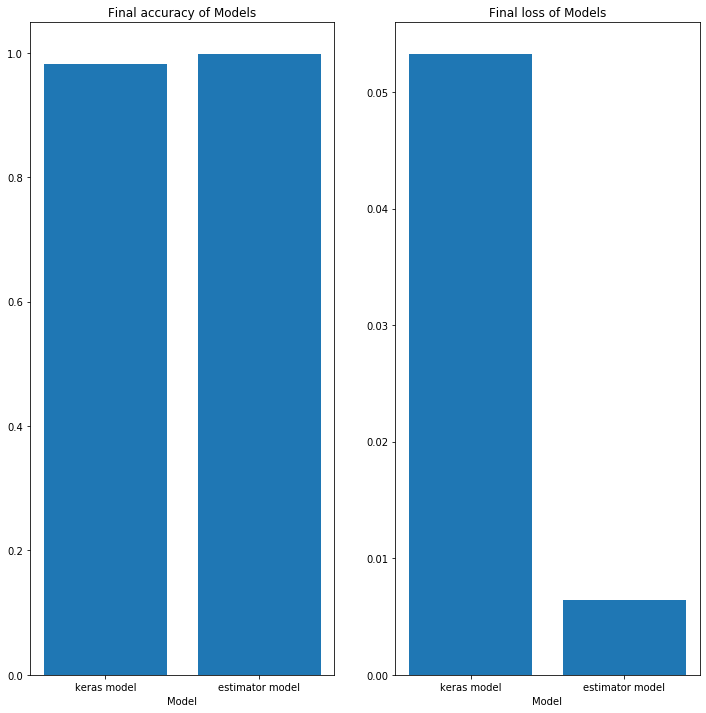

In [0]:
est_acc = history_estimator["accuracy"]
est_loss = history_estimator["loss"]

keras_acc = history_keras.history["accuracy"][29]
keras_loss = history_keras.history["loss"][29]

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.bar(["keras model", "estimator model"], [keras_acc, est_acc])
plt.xlabel("Model")
plt.title("Final accuracy of Models")

plt.subplot(1, 2, 2)
plt.bar(["keras model", "estimator model"], [keras_loss, est_loss])
plt.xlabel("Model")
plt.title("Final loss of Models")